In [1]:
from google.colab import files
uploaded = files.upload()


Saving user-wallet-transactions.json to user-wallet-transactions.json


In [2]:
import os
print("File exists:", os.path.exists("user-wallet-transactions.json"))


File exists: True


In [9]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [18]:
wallet_stats = defaultdict(lambda: {
    'deposit_count': 0,
    'borrow_count': 0,
    'repay_count': 0,
    'redeem_count': 0,
    'liquidation_count': 0,
    'total_amount': 0
})

for tx in tqdm(data):
    wallet = tx.get('userWallet')
    action = tx.get('action', '').lower()
    amount_str = tx.get('actionData', {}).get('amount', '0')

    try:
        amount = float(amount_str) / 1e6  # normalize USDC decimals
    except:
        amount = 0.0

    if not wallet:
        continue

    if action == 'deposit':
        wallet_stats[wallet]['deposit_count'] += 1
    elif action == 'borrow':
        wallet_stats[wallet]['borrow_count'] += 1
    elif action == 'repay':
        wallet_stats[wallet]['repay_count'] += 1
    elif action == 'redeemunderlying':
        wallet_stats[wallet]['redeem_count'] += 1
    elif action == 'liquidationcall':
        wallet_stats[wallet]['liquidation_count'] += 1

    wallet_stats[wallet]['total_amount'] += amount


100%|██████████| 100000/100000 [00:00<00:00, 487169.35it/s]


In [20]:
df_features = pd.DataFrame([
    {
        'wallet': wallet,
        **stats
    } for wallet, stats in wallet_stats.items()
])

print("DataFrame created with shape:", df_features.shape)
df_features.head()


DataFrame created with shape: (3497, 7)


,wallet,deposit_count,borrow_count,repay_count,redeem_count,liquidation_count,total_amount
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,2.000000e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,1.450000e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,5.000000e+09
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,4.835297e+12
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,1.735192e+17


In [21]:
def score_wallet(row):
    score = 600
    score += row['deposit_count'] * 5
    score += row['repay_count'] * 5
    score += row['borrow_count'] * 2
    score -= row['liquidation_count'] * 10
    score += min(row['total_amount'] / 100, 100)
    return max(0, min(1000, score))

df_features['credit_score'] = df_features.apply(score_wallet, axis=1)
df_features[['wallet', 'credit_score']].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,625.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,705.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,710.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,700.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000.0


In [23]:
output_path = 'credit_scores.csv'
df_features.to_csv(output_path, index=False)
print(f"✅ Credit scores saved to {output_path}")


✅ Credit scores saved to credit_scores.csv


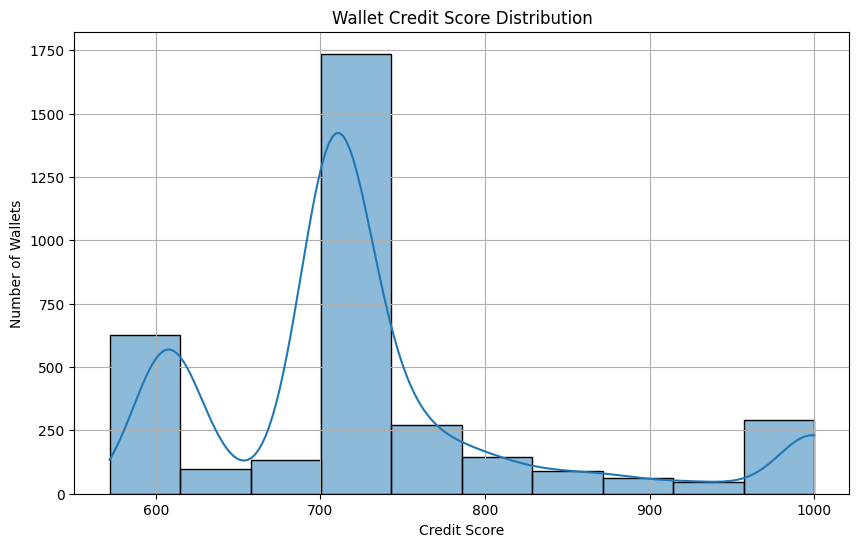

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df_features['credit_score'], bins=10, kde=True)
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()
